In [1]:
from glob import glob
import torch
# átt_path = '/ephemeral/tbakr/watermark-analysis/attacked/3/diffuser'
átt_path ='/ephemeral/tbakr/watermark-analysis/attacked/3/test_dataset_trw_klvae16'
wm_path =  '/ephemeral/tbakr/watermark-analysis/cache/test_dataset_trw'
from PIL import Image
from watermarks.TrwStableDiffusion import TrwStableDiffusion
import torchvision.transforms as transforms
from tqdm import tqdm
# from metrics import roc_auc_score
import numpy as np
import pandas as pd

/ephemeral/tbakr/miniconda3/envs/ada-waves/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ddim = TrwStableDiffusion()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:  67%|██████▋   | 4/6 [00:00<00:00,  8.37it/s]/ephemeral/tbakr/miniconda3/envs/ada-waves/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  9.47it/s]
The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [3]:
for wm_path in glob('/ephemeral/tbakr/watermark-analysis/attacked/3/*'):
    att_img_paths = sorted(glob(átt_path + '/*.png'), key=lambda x: int(x.split('/')[-1].split('.')[0].split('_')[1]))
    wm_img_paths = sorted(glob(wm_path + '/*.png'), key=lambda x: int(x.split('/')[-1].split('.')[0].split('_')[1]))
    true_labels = []
    wm_images_list, nwm_images_list = [], []
    var_wm_list, var_nwm_list = [], []
    to_tensor = transforms.ToTensor()
    batch_size = 32
    for i in tqdm(range(0,len(att_img_paths),batch_size)):
        att_images = list(map(lambda x: Image.open(x) , att_img_paths[i:i+batch_size]))
        wm_images = list(map(lambda x: Image.open(x) , wm_img_paths[i:i+batch_size]))
        att_images = torch.stack(list(map(to_tensor, att_images)))
        att_images = att_images.to('cuda:7')
        wm_images = torch.stack(list(map(to_tensor, wm_images)))
        wm_images = wm_images.to('cuda:7')
        with torch.no_grad():
            x=ddim.invert(att_images)    
            y=ddim.invert(wm_images)
        #
            x=torch.fft.fftshift(
            torch.fft.fft2(x[0]), dim=(-1, -2)
                ).to('cuda:7')
            y = torch.fft.fftshift(
            torch.fft.fft2(y[0]), dim=(-1, -2)
                ).to('cuda:7')  
            
            reversed_latents_no_w_fft = ddim.get_random_latents(batch_size=batch_size)
            reversed_latents_no_w_fft = torch.fft.fftshift(
            torch.fft.fft2(reversed_latents_no_w_fft.to('cuda:7')), dim=(-1, -2)
                )
            watermarking_mask = ddim.trw.get_watermarking_mask(reversed_latents_no_w_fft).to('cuda:7')
            for j in range(batch_size):
                nwm_images_list.append(
                    torch.abs(
                        reversed_latents_no_w_fft[j][watermarking_mask[j]]
                        - y[j][watermarking_mask[j]]
                    )
                )
                wm_images_list.append(
                    torch.abs(
                        x[j][watermarking_mask[j]]
                        - y[j][watermarking_mask[j]]
                    )
                )    
    true_labels = [0]*len(wm_images_list)*317 + [1]*len(nwm_images_list)*317
    pred_labels = np.array(list(map(lambda x: x.cpu().numpy(), wm_images_list)) + list(map(lambda x: x.cpu().numpy(), nwm_images_list))).flatten()
    auc = roc_auc_score(true_labels, pred_labels)
    # save that to a csv
    link="_".join(wm_path.split('/')[-2:])
    pd.DataFrame.from_dict({'auc':auc}, orient='index').to_csv(f'/ephemeral/tbakr/watermark-analysis/performance/{link}.csv')

  0%|          | 0/32 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 7 has a total capacity of 47.54 GiB of which 568.94 MiB is free. Process 2506339 has 39.95 GiB memory in use. Including non-PyTorch memory, this process has 7.02 GiB memory in use. Of the allocated memory 6.65 GiB is allocated by PyTorch, and 69.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

/tmp/ipykernel_2506339/194043501.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  intersected_area = np.trapz(intersection, x_vals)  # Use x_vals for integration


Histogram 1 - Intersected Area: 0.4373
Histogram 2 - Intersected Area: 0.8434
Histogram 3 - Intersected Area: 0.8464
Histogram 4 - Intersected Area: 0.5531
Histogram 5 - Intersected Area: 0.7490
Histogram 6 - Intersected Area: 0.4074
Histogram 7 - Intersected Area: 0.5248
Histogram 8 - Intersected Area: 0.4481


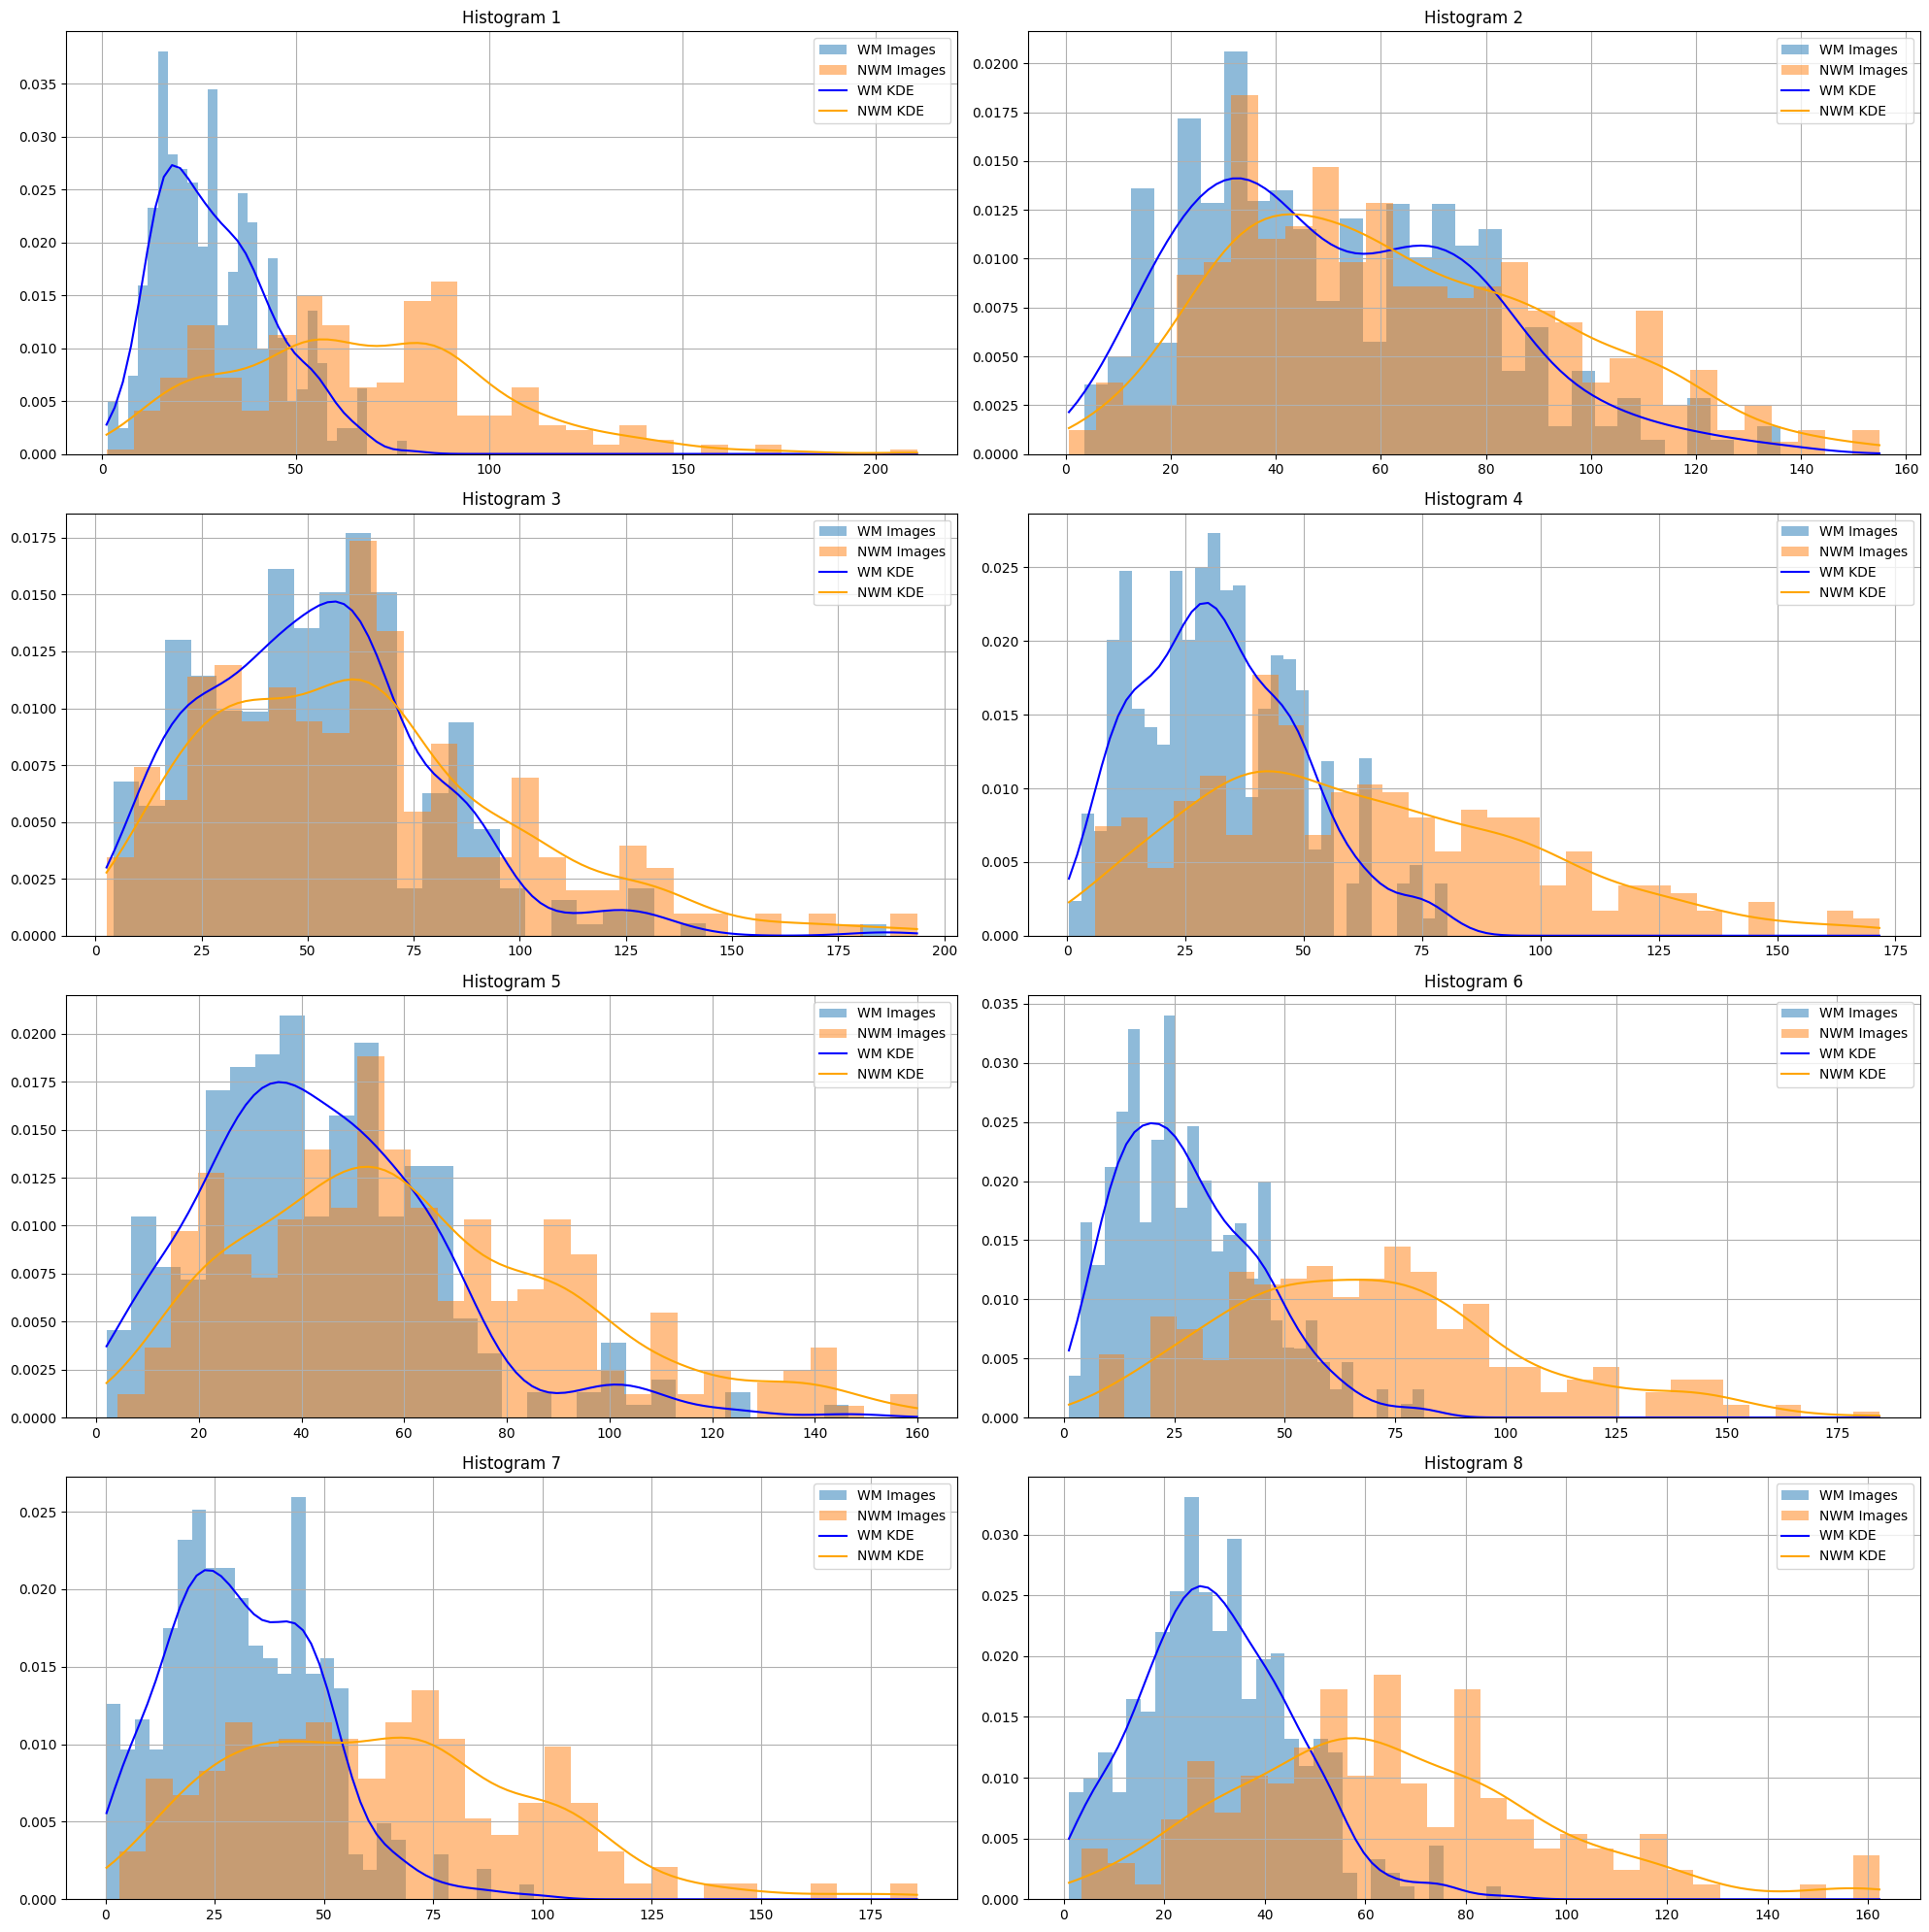

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(4, 2, figsize=(20, 20))  # 4 rows, 2 columns
for i in range(8):
    row, col = divmod(i, 2)  # Calculate row and column indices
    
    # Data for histograms
    wm_data = wm_images_list[i].cpu().numpy()  # Ensure data is on CPU
    nwm_data = nwm_images_list[i].cpu().numpy()
    
    # Plot histograms
    ax[row, col].hist(wm_data, bins=30, alpha=0.5, label="WM Images", density=True)
    ax[row, col].hist(nwm_data, bins=30, alpha=0.5, label="NWM Images", density=True)
    
    # Interpolated curves
    x_vals = np.linspace(min(wm_data.min(), nwm_data.min()), max(wm_data.max(), nwm_data.max()), 100)
    wm_kde = gaussian_kde(wm_data)
    nwm_kde = gaussian_kde(nwm_data)
    
    pdf1 = wm_kde(x_vals)  # Use `x_vals` (already a NumPy array)
    pdf2 = nwm_kde(x_vals)
    ax[row, col].plot(x_vals, pdf1, color='blue', label="WM KDE")
    ax[row, col].plot(x_vals, pdf2, color='orange', label="NWM KDE")
    
    # Compute intersection
    intersection = np.minimum(pdf1, pdf2)
    intersected_area = np.trapz(intersection, x_vals)  # Use x_vals for integration
    print(f"Histogram {i+1} - Intersected Area: {intersected_area:.4f}")
    
    # Add title, legend, and grid
    ax[row, col].set_title(f"Histogram {i+1}")
    ax[row, col].legend(loc='upper right')
    ax[row, col].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()
